In [32]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
# import plotly as pl

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import RobustScaler
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error
from sklearn.pipeline import make_pipeline
from sklearn.svm import SVR
from sklearn.model_selection import cross_val_score
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.tree import plot_tree
from sklearn.preprocessing import StandardScaler
import seaborn as sns
from sklearn.metrics import roc_curve, auc

import warnings
warnings.filterwarnings("ignore")

In [33]:
from tensorflow.python.client import device_lib
# tensorflow gpu는 python=3.7 기반에 conda install tensorflow-gpu==2.6.0
print(device_lib.list_local_devices())

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 4506647477536030690
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 5711593472
locality {
  bus_id: 1
  links {
  }
}
incarnation: 15870476275841462229
physical_device_desc: "device: 0, name: NVIDIA GeForce RTX 3070 Ti, pci bus id: 0000:01:00.0, compute capability: 8.6"
]


In [34]:
path = "data/Battery_RUL.csv"

In [35]:
data = pd.read_csv(path)

In [36]:
data.head()

,Cycle_Index,Discharge Time (s),Decrement 3.6-3.4V (s),Max. Voltage Dischar. (V),Min. Voltage Charg. (V),Time at 4.15V (s),Time constant current (s),Charging time (s),RUL
0,1.0,2595.30,1151.488500,3.670,3.211,5460.001,6755.01,10777.82,1112
1,2.0,7408.64,1172.512500,4.246,3.220,5508.992,6762.02,10500.35,1111
2,3.0,7393.76,1112.992000,4.249,3.224,5508.993,6762.02,10420.38,1110
3,4.0,7385.50,1080.320667,4.250,3.225,5502.016,6762.02,10322.81,1109
4,6.0,65022.75,29813.487000,4.290,3.398,5480.992,53213.54,56699.65,1107


In [37]:
data.shape

(15064, 9)

In [38]:
# 다음 컬럼들은 RUL에 관계가 없기 때문에 제거한다.
data=data.drop(['Cycle_Index','Discharge Time (s)', 'Decrement 3.6-3.4V (s)', 'Time constant current (s)','Charging time (s)'],axis=1)

In [39]:
data.head()

,Max. Voltage Dischar. (V),Min. Voltage Charg. (V),Time at 4.15V (s),RUL
0,3.670,3.211,5460.001,1112
1,4.246,3.220,5508.992,1111
2,4.249,3.224,5508.993,1110
3,4.250,3.225,5502.016,1109
4,4.290,3.398,5480.992,1107


## Modeling and Predections

In [40]:
X = data.drop(['RUL'], axis=1)
y = data['RUL']

In [41]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=2023, shuffle =True)

In [42]:
class Pipeline:
    def __init__(self, scalar):
        self.scalar = scalar
    
    def fit(self, X, y):
        X = self.scalar.fit_transform(X)
        return X, y
    
    def transform(self, X, y):
        X = self.scalar.transform(X)
        return X, y

In [43]:
from sklearn.preprocessing import RobustScaler
robust = RobustScaler()
pipeline = Pipeline(robust)

In [44]:
X_train_s, y_train_s = pipeline.fit(X_train, y_train)
X_test_s, y_test_s = pipeline.transform(X_test, y_test)

In [45]:
# 분석단위의 shape
nfeatures = X_train_s.shape[1] #num of columns
nfeatures

3

In [46]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.backend import clear_session
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import *
from sklearn.metrics import r2_score

In [47]:
# 메모리 정리
clear_session()

# Sequential 타입
model = Sequential(Dense(1, input_shape=(nfeatures,)) )

# 모델요약
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 1)                 4         
Total params: 4
Trainable params: 4
Non-trainable params: 0
_________________________________________________________________


In [48]:
model.compile( optimizer= Adam(learning_rate=0.1), loss = 'mse')

In [49]:
hist = model.fit(X_train_s, y_train_s, epochs = 50 , validation_split= .2 ).history

Epoch 1/50
253/253 [==============================] - 1s 2ms/step - loss: 383585.0312 - val_loss: 366854.0000
Epoch 2/50
253/253 [==============================] - 0s 2ms/step - loss: 342489.6875 - val_loss: 329597.5938
Epoch 3/50
253/253 [==============================] - 0s 1ms/step - loss: 309225.6250 - val_loss: 297856.6875
Epoch 4/50
253/253 [==============================] - 0s 1ms/step - loss: 279908.3125 - val_loss: 269669.1562
Epoch 5/50
253/253 [==============================] - 0s 1ms/step - loss: 253275.0156 - val_loss: 244027.4844
Epoch 6/50
253/253 [==============================] - 0s 1ms/step - loss: 228914.0312 - val_loss: 220696.4688
Epoch 7/50
253/253 [==============================] - 0s 2ms/step - loss: 206683.1250 - val_loss: 199378.3438
Epoch 8/50
253/253 [==============================] - 0s 2ms/step - loss: 186452.6875 - val_loss: 179927.5000
Epoch 9/50
253/253 [==============================] - 0s 1ms/step - loss: 168023.7969 - val_loss: 162191.9531
Epoch 10/5

In [50]:
# 함수로 만들어서 사용합시다.
def dl_history_plot(history):
    plt.figure(figsize=(10,6))
    plt.plot(history['loss'], label='train_err', marker = '.')
    plt.plot(history['val_loss'], label='val_err', marker = '.')

    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend()
    plt.grid()
    plt.show()

In [51]:
def eval_graph(y_valid, y_pred, cnt):
    plt.figure(figsize=(18,6))
    plt.plot(y_valid.values[:cnt], label='Actual',  marker = 'o')
    plt.plot(y_pred[:cnt], label='Predicted', alpha = 0.8,  marker = 'o')
    plt.legend()
    plt.ylabel('RUL')
    plt.show()


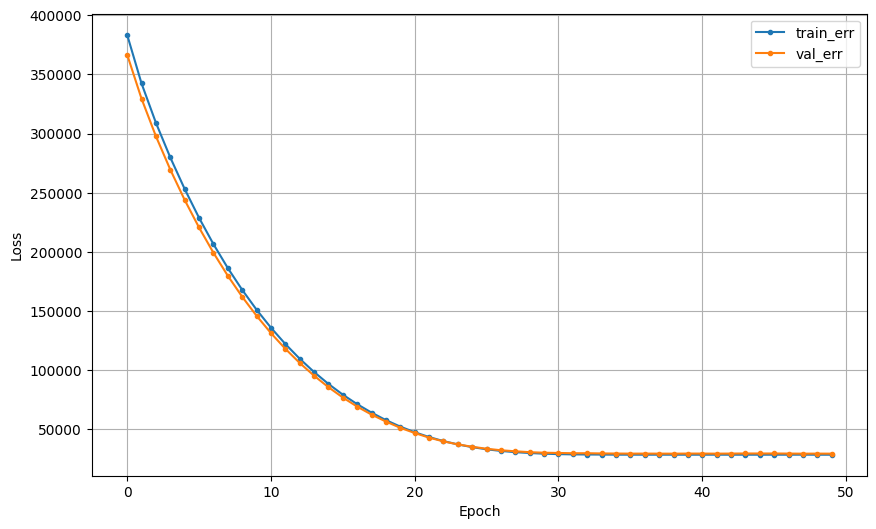

In [52]:
dl_history_plot(hist)

In [53]:
def RUL_metric(y_valid, y_pred, threshold=10):

    error = y_valid.values - y_pred.reshape(-1)
    per = np.where(error<=threshold, 1, 0)
    
    return sum(per) / len(per)

In [54]:
pred = model.predict(X_test_s)

print(f'RMSE : {mean_squared_error(y_test_s, pred, squared=False)}')
print(f'MAE  : {mean_absolute_error(y_test_s, pred)}')
print(f'MAPE : {mean_absolute_percentage_error(y_test_s, pred)}')
print(f'R2 : {r2_score(y_test_s, pred)}')
print(f'RUL_metric : {RUL_metric(y_test_s, pred, threshold=50)}')

RMSE : 158.7891269050095
MAE  : 108.05324183101148
MAPE : 3142180990633479.0
R2 : 0.7562388459619993
RUL_metric : 0.6739742558326629


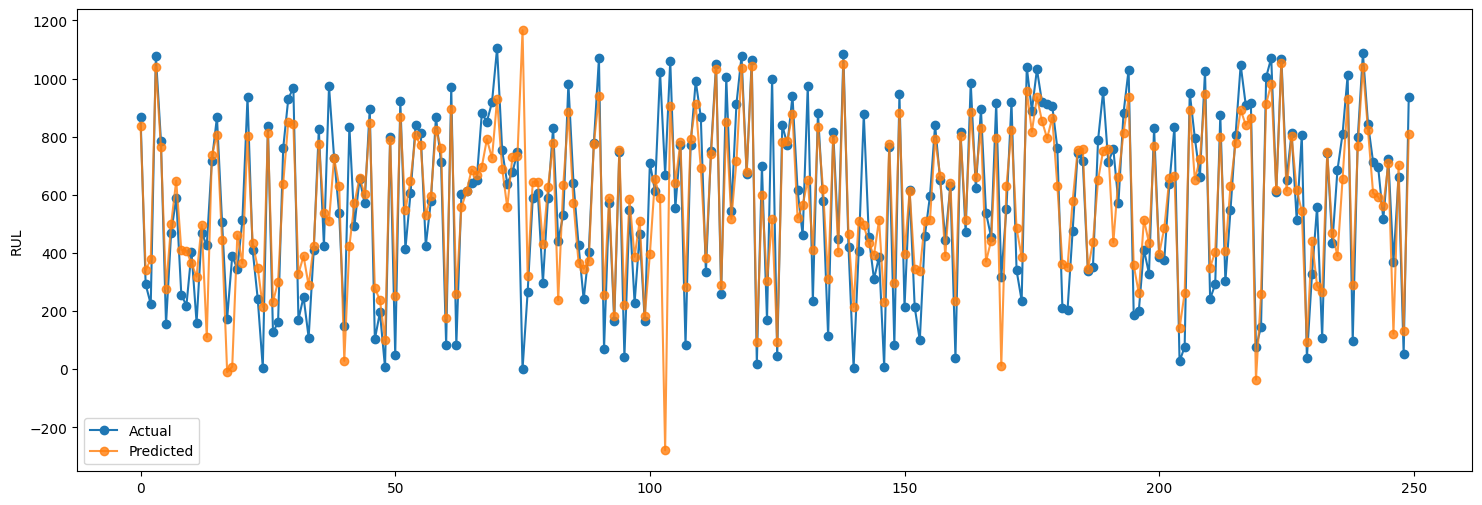

In [55]:

eval_graph(y_test_s, pred, 250)

In [56]:
clear_session()

model = Sequential([
    Dense(32, input_shape=(nfeatures,), activation='ELU'),
    Dense(16, input_shape=(32,), activation='ELU'),
    Dropout(0.5),
    Dense(1, input_shape=(16,), activation='ELU')
])

model.compile(optimizer=Adam(learning_rate=0.01), loss='mse')

hist = model.fit(X_train_s, y_train_s, epochs=100, validation_split=0.2, verbose=0).history

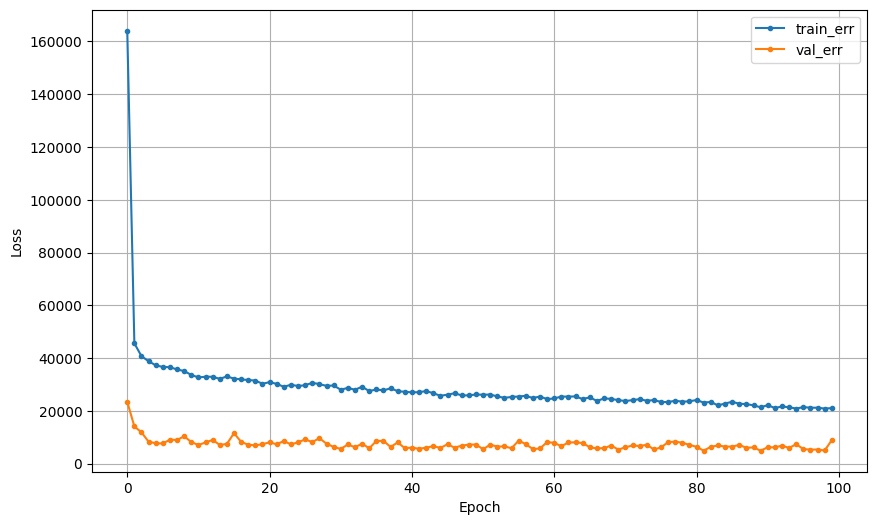

In [57]:
dl_history_plot(hist)

In [58]:
pred = model.predict(X_test_s)

print(f'RMSE : {mean_squared_error(y_test_s, pred, squared=False)}')
print(f'MAE  : {mean_absolute_error(y_test_s, pred)}')
print(f'MAPE : {mean_absolute_percentage_error(y_test_s, pred)}')
print(f'R2 : {r2_score(y_test_s, pred)}')
print(f'RUL_metric : {RUL_metric(y_test_s, pred, threshold=50)}')

RMSE : 88.64466972066823
MAE  : 73.43781107519052
MAPE : 1634901256348867.8
R2 : 0.9240324311353229
RUL_metric : 0.46379726468222043


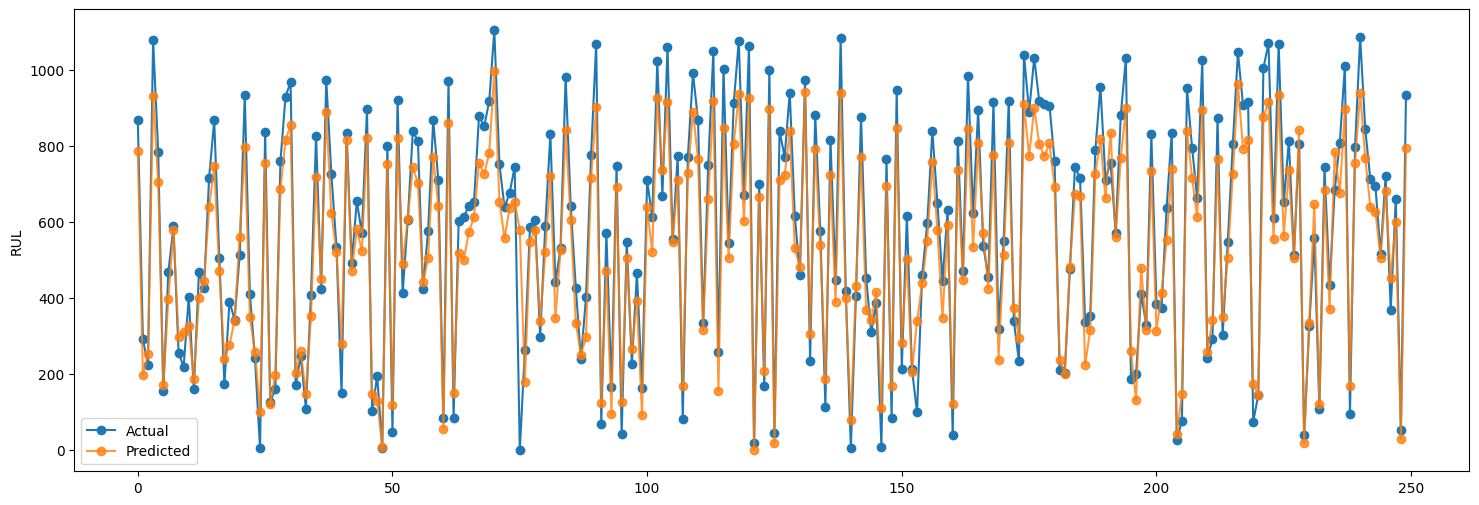

In [59]:
eval_graph(y_test_s, pred, 250)

In [60]:
clear_session()
from tensorflow.keras.regularizers import l1, l2

model = Sequential([
    Dense(32, input_shape=(nfeatures,), activation='ELU', kernel_regularizer = l1(0.01)),
    Dense(16, input_shape=(32,), activation='ELU', kernel_regularizer = l1(0.01)),
    Dropout(0.5),
    Dense(1, input_shape=(16,), activation='ELU')
])

model.compile(optimizer=Adam(learning_rate=0.01), loss='mse')

hist = model.fit(X_train_s, y_train_s, epochs=100, validation_split=0.2, verbose=0).history

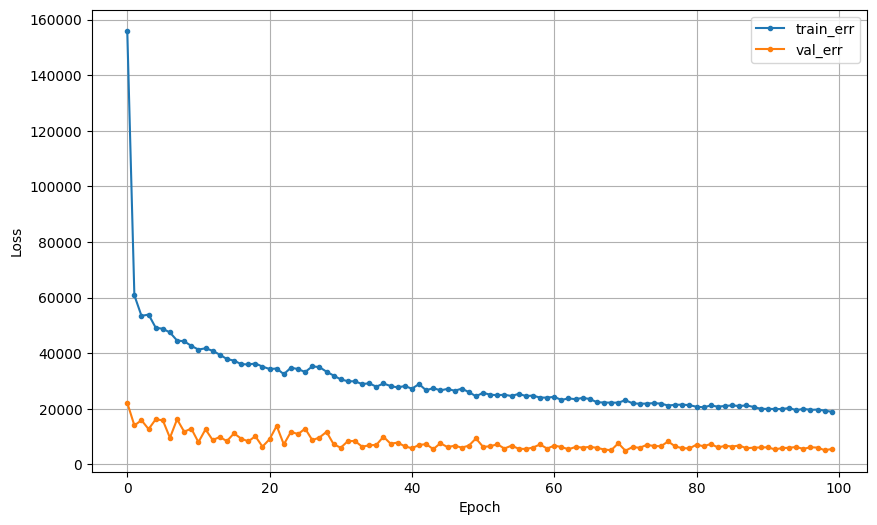

RMSE : 64.91792916963102
MAE  : 48.00343331585512
MAPE : 1936951717900100.5
R2 : 0.9592570668632302
RUL_metric : 0.9519308125502816


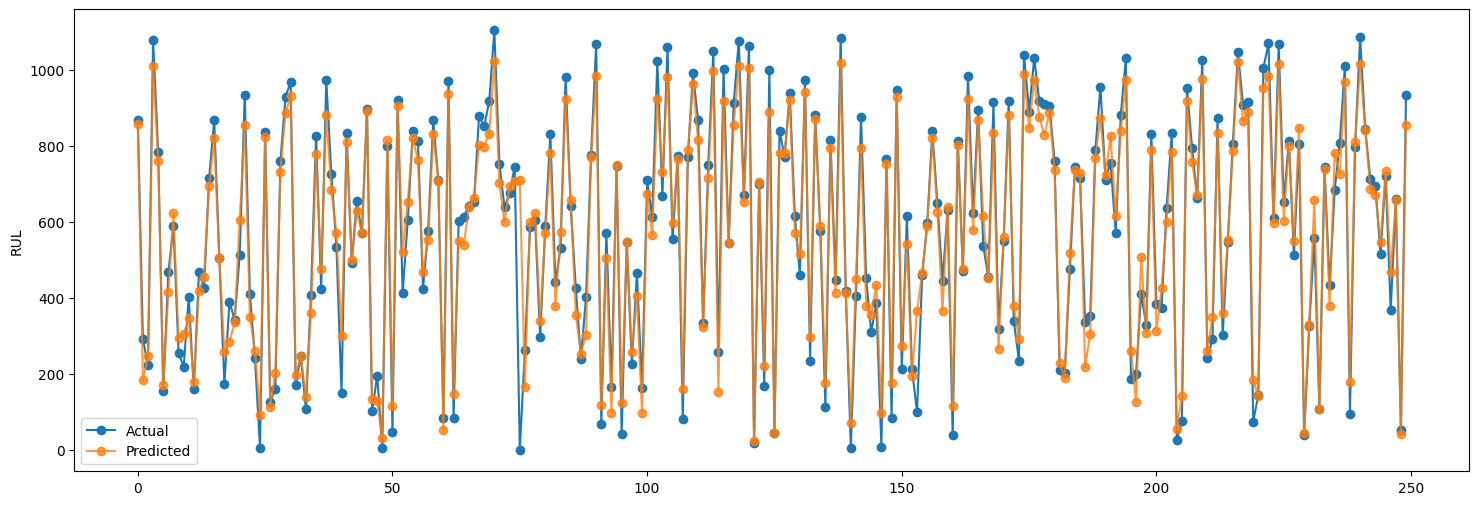

In [62]:
dl_history_plot(hist)

pred = model.predict(X_test_s)

print(f'RMSE : {mean_squared_error(y_test_s, pred, squared=False)}')
print(f'MAE  : {mean_absolute_error(y_test_s, pred)}')
print(f'MAPE : {mean_absolute_percentage_error(y_test_s, pred)}')
print(f'R2 : {r2_score(y_test_s, pred)}')
print(f'RUL_metric : {RUL_metric(y_test_s, pred, threshold=100)}')

eval_graph(y_test_s, pred, 250)